# Project 7: Implémentez un modèle de scoring - Model

In [24]:
import dill
from function_utils import *
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from lightgbm import LGBMClassifier
from lime import lime_tabular
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from preprocessing import Preprocessing
import re
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# 1. preprocessing

In [2]:
app_train, app_test = Preprocessing().run()

# 2. Preparer les données

In [3]:
app_train = app_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
app_test = app_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

<AxesSubplot:title={'center':'training vs testing samples histogram'}, ylabel='Count'>

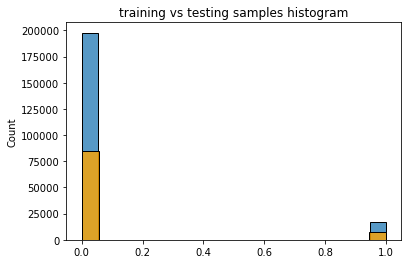

In [4]:
X = app_train.drop(columns = ['TARGET'])
y = app_train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

plt.title("training vs testing samples histogram")
sns.histplot(y_train.values)
sns.histplot(y_test.values, color="orange", alpha=.8)

In [5]:
from sklearn.neighbors import KNeighborsClassifier
train_data_for_neighbors = X_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATION']].fillna(0)
train_target = y_train
test_data_for_neighbors = X_test[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATION']].fillna(0)

knn = KNeighborsClassifier(500, n_jobs = -1)
knn.fit(train_data_for_neighbors, train_target)
train_500_neighbors = knn.kneighbors(train_data_for_neighbors)[1]
test_500_neighbors = knn.kneighbors(test_data_for_neighbors)[1]

#adding the means of targets of 500 neighbors to new column
X_train['TARGET_NEIGHBORS_500_MEAN'] = [y_train.iloc[ele].mean() for ele in train_500_neighbors]
X_test['TARGET_NEIGHBORS_500_MEAN'] = [y_train.iloc[ele].mean() for ele in test_500_neighbors]

In [6]:
train_data_for_neighbors = X[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATION']].fillna(0)
train_target = y

knn.fit(train_data_for_neighbors, train_target)
train_500_neighbors = knn.kneighbors(train_data_for_neighbors)[1]

#adding the means of targets of 500 neighbors to new column
X['TARGET_NEIGHBORS_500_MEAN'] = [y.iloc[ele].mean() for ele in train_500_neighbors]

In [7]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
X = X.fillna(0)

In [8]:
def features_importance(X, model):
    """Plot features importance."""
    features_names = X.columns
    d = {features_names[idx] :  model.feature_importances_[idx] for idx, val in enumerate(model.feature_importances_)}
    df = pd.DataFrame(d.items(), columns=['feature', 'value'])

    df["abs_value"] = df["value"].apply(lambda x: abs(x))
    df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
    df = df.sort_values("abs_value", ascending=False)

    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    fig = sns.barplot(x="feature",
                y="value",
                data=df.head(20),
               palette=df.head(20)["colors"])
    fig = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
    fig = ax.set_title("Feature importance", fontsize=25)
    fig = ax.set_ylabel("Coef", fontsize=22)
    fig = ax.set_xlabel("Feature Name", fontsize=22)

# 3. Model

In [9]:
ftwo_scorer = make_scorer(fbeta_score, beta=3)
kfold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

## 3.1 Model raw data

### 3.1.1 Random Forest

In [9]:
rf = RandomForestClassifier(random_state=100, n_jobs=-1, class_weight = 'balanced')
scores = cross_val_score(rf, X, y, cv=kfold, scoring=ftwo_scorer)
scores

array([0.00223674, 0.00156593, 0.00268426, 0.0031315 , 0.00447267])

[+] fbeta score : 0.49695328154984425
[+] roc score : 0.5011399065911297


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


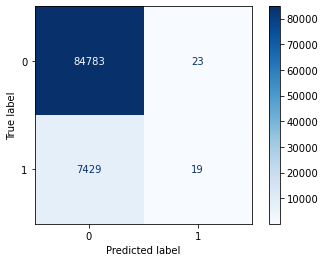

In [9]:
rf = RandomForestClassifier(random_state=100, n_jobs=-1, class_weight = 'balanced')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

results(rf, X_test, y_test, y_pred)

### 3.1.2 Xgboost

In [12]:
clf  = XGBClassifier(scale_pos_weight=3)
scores = cross_val_score(clf, X, y, cv=kfold, scoring=ftwo_scorer)

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:54:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[+] fbeta score : 0.5958303432958045
[+] roc score : 0.5933634374029583


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


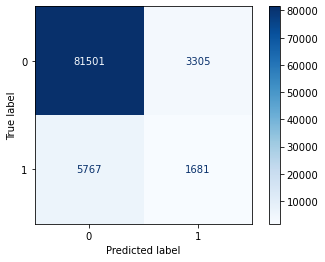

In [11]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
results(clf, X_test, y_test, y_pred)

### 3.1.3 LGB

In [13]:
lgb = LGBMClassifier(random_state=100, n_jobs=-1, class_weight = 'balanced')
scores = cross_val_score(lgb, X, y, cv=kfold, scoring=ftwo_scorer)
scores

array([0.53388507, 0.54624079, 0.53769315, 0.52836162, 0.54059966])

[+] fbeta score : 0.6356254707449758
[+] roc score : 0.7024230895798493


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


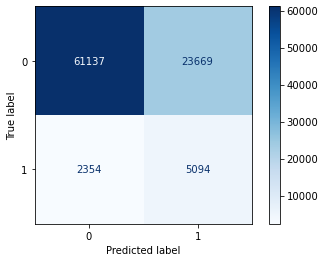

In [14]:
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)

results(lgb, X_test, y_test, y_pred)

### 3.1.4 Multi-layer Perceptron

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[+] fbeta score : 0.23379330261291012
[+] roc score : 0.5


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


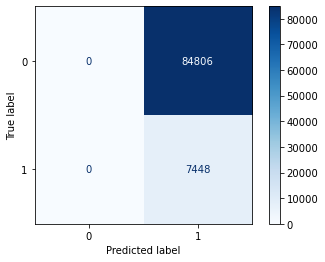

In [8]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

results(clf, X_test, y_test, y_pred)

## 3.2. Model Under Sampling

<AxesSubplot:title={'center':'training vs testing samples histogram'}, ylabel='Count'>

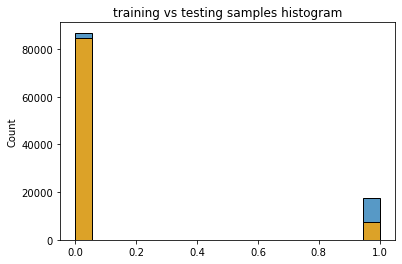

In [15]:
undersample = NearMiss(version=1, n_neighbors=4, sampling_strategy=0.2)

X_train_u, y_train_u = undersample.fit_resample(X_train, y_train)

plt.title("training vs testing samples histogram")
sns.histplot(y_train_u.values)
sns.histplot(y_test.values, color="orange", alpha=.8)

### 3.2.1 Random 

In [16]:
rf = RandomForestClassifier(random_state=100, n_jobs=-1)
scores = cross_val_score(rf, X, y, cv=kfold, scoring=ftwo_scorer)
scores

array([0.00134243, 0.00111867, 0.00178983, 0.00111874, 0.00134243])

[+] fbeta score : 0.49688575528759693
[+] roc score : 0.5162678343797139


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


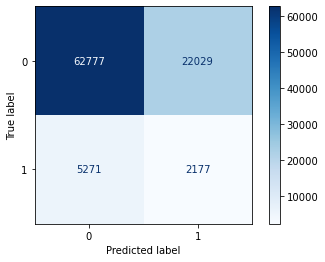

In [17]:
rf.fit(X_train_u, y_train_u)
y_pred = rf.predict(X_test)

results(rf, X_test, y_test, y_pred)

### 3.2.2 Xgboost

In [18]:
clf  = XGBClassifier()
scores = cross_val_score(clf, X, y, cv=kfold, scoring=ftwo_scorer)

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:04:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:04:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:05:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:06:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:07:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[+] fbeta score : 0.49016541282661236
[+] roc score : 0.5337117972141534


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


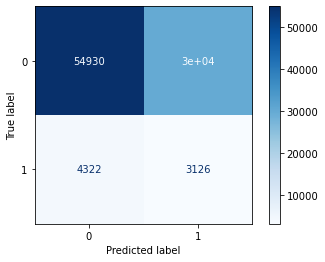

In [21]:
clf.fit(X_train_u, y_train_u)
y_pred = clf.predict(X_test)
results(clf, X_test, y_test, y_pred)

### 3.2.3 LGB

In [22]:
lgb = LGBMClassifier(random_state=100, n_jobs=-1)
scores = cross_val_score(lgb, X, y, cv=kfold, scoring=ftwo_scorer)
scores

array([0.53388507, 0.54624079, 0.53769315, 0.52836162, 0.54059966])

[+] fbeta score : 0.47537591108532795
[+] roc score : 0.593339966572598


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


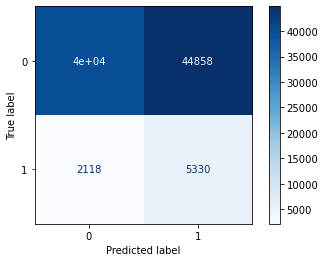

In [24]:
lgb.fit(X_train_u, y_train_u)
y_pred = lgb.predict(X_test)

results(lgb, X_test, y_test, y_pred)

## 3.3. Model with over and under sampling

<AxesSubplot:title={'center':'training vs testing samples histogram'}, ylabel='Count'>

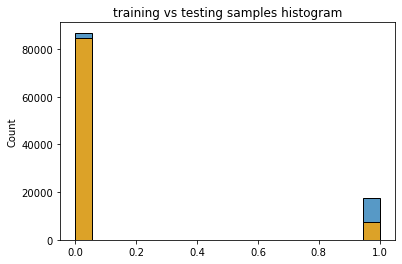

In [29]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_u_o, y_train_u_o = oversample.fit_resample(X_train_u, y_train_u)


plt.title("training vs testing samples histogram")
sns.histplot(y_train_u.values)
sns.histplot(y_test.values, color="orange", alpha=.8)

### 3.3.1 Random Forest

[+] fbeta score : 0.47537591108532795
[+] roc score : 0.593339966572598


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


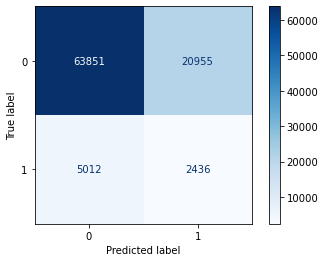

In [26]:
rf.fit(X_train_u_o, y_train_u_o)
y_pred = lgb.predict(X_test)

results(rf, X_test, y_test, y_pred)

### 3.3.2 Xgboost

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:15:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[+] fbeta score : 0.4865516691929213
[+] roc score : 0.5877293203825308


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


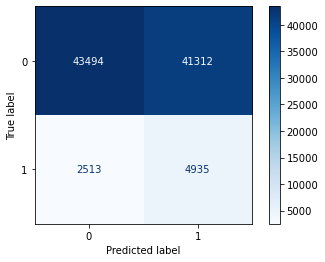

In [27]:
clf.fit(X_train_u_o, y_train_u_o)
y_pred = clf.predict(X_test)
results(clf, X_test, y_test, y_pred)

In [ ]:
features_names = app_train.drop(columns = ['TARGET']).columns
d = {features_names[idx] :  lgb.feature_importances_[idx] for idx, val in enumerate(lgb.feature_importances_)}
df = pd.DataFrame(d.items(), columns=['feature', 'value'])

df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
fig = sns.barplot(x="feature",
            y="value",
            data=df.head(20),
           palette=df.head(20)["colors"])
fig = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
fig = ax.set_title("Feature importance", fontsize=25)
fig = ax.set_ylabel("Coef", fontsize=22)
fig = ax.set_xlabel("Feature Name", fontsize=22)

### 3.3.3 LGB

[+] fbeta score : 0.47451113692853997
[+] roc score : 0.5898665084926378


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


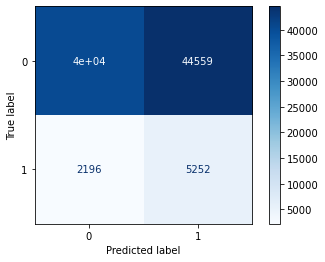

In [28]:
lgb.fit(X_train_u_o, y_train_u_o)
y_pred = lgb.predict(X_test)

results(lgb, X_test, y_test, y_pred)

## 3.4 Model with oversampling
### 3.4.1 SMOTE

<AxesSubplot:title={'center':'training vs testing samples histogram'}, ylabel='Count'>

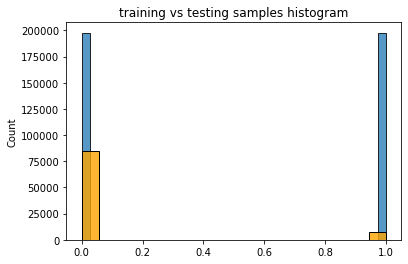

In [126]:
oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

plt.title("training vs testing samples histogram")
sns.histplot(y_train_smote.values)
sns.histplot(y_test.values, color="orange", alpha=.8)

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:11:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[+] fbeta score : 0.5234459161368639
[+] roc score : 0.5245391481481472


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


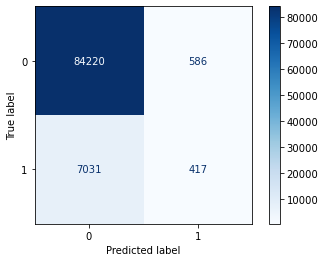

In [43]:
clf.fit(X_train_smote, y_train_smote)
y_pred = clf.predict(X_test)
results(clf, X_test, y_test, y_pred)

[+] fbeta score : 0.5086272318157238
[+] roc score : 0.5114489111472541


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


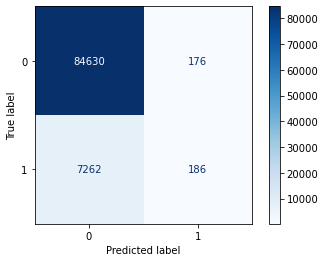

In [35]:
lgb.fit(X_train_smote, y_train_smote)
y_pred = lgb.predict(X_test)

results(lgb, X_test, y_test, y_pred)

### 3.4.2 RandomOverSampler

<AxesSubplot:title={'center':'training vs testing samples histogram'}, ylabel='Count'>

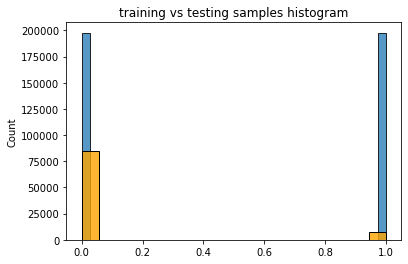

In [10]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_o, y_train_o = oversample.fit_resample(X_train, y_train)

plt.title("training vs testing samples histogram")
sns.histplot(y_train_o.values)
sns.histplot(y_test.values, color="orange", alpha=.8)

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:26:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[+] fbeta score : 0.641967022131348
[+] roc score : 0.6896327741691258


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


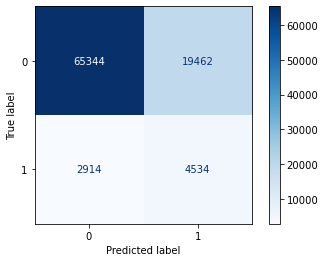

In [131]:
clf.fit(X_train_o, y_train_o)
y_pred = clf.predict(X_test)
results(clf, X_test, y_test, y_pred)

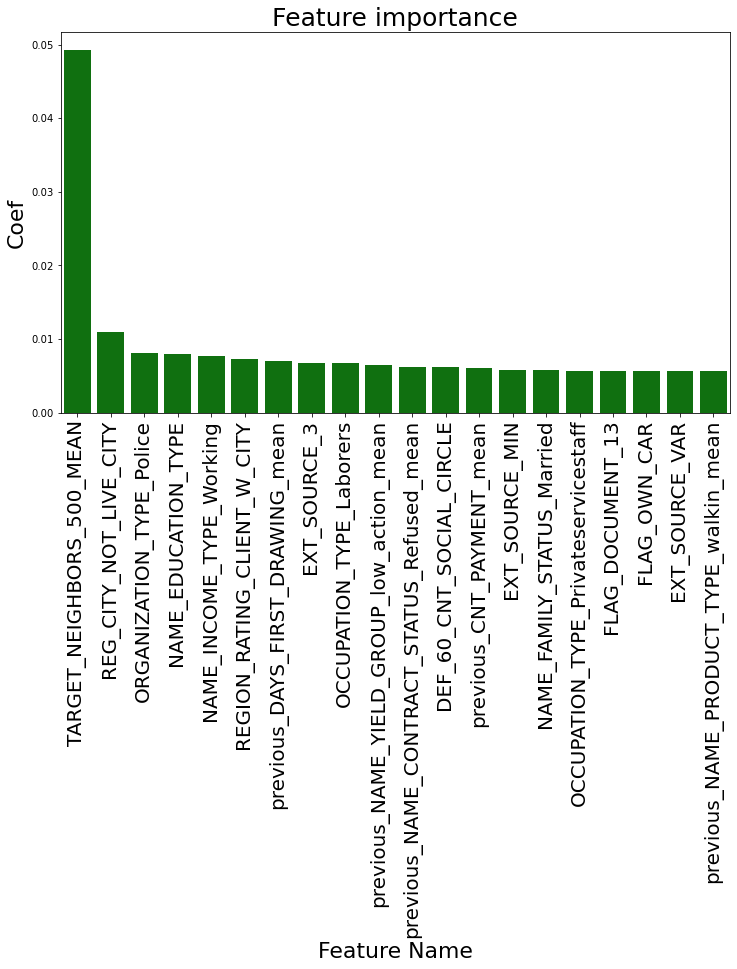

In [134]:
features_importance(X, clf)

[+] fbeta score : 0.6355823931237328
[+] roc score : 0.7024888823149104


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


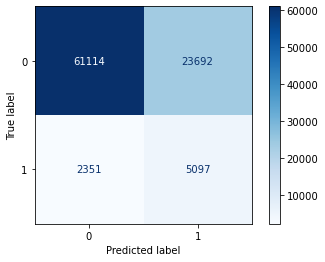

In [13]:
lgb = LGBMClassifier(random_state=100, n_jobs=-1)
lgb.fit(X_train_o, y_train_o)
y_pred = lgb.predict(X_test)

results(lgb, X_test, y_test, y_pred)

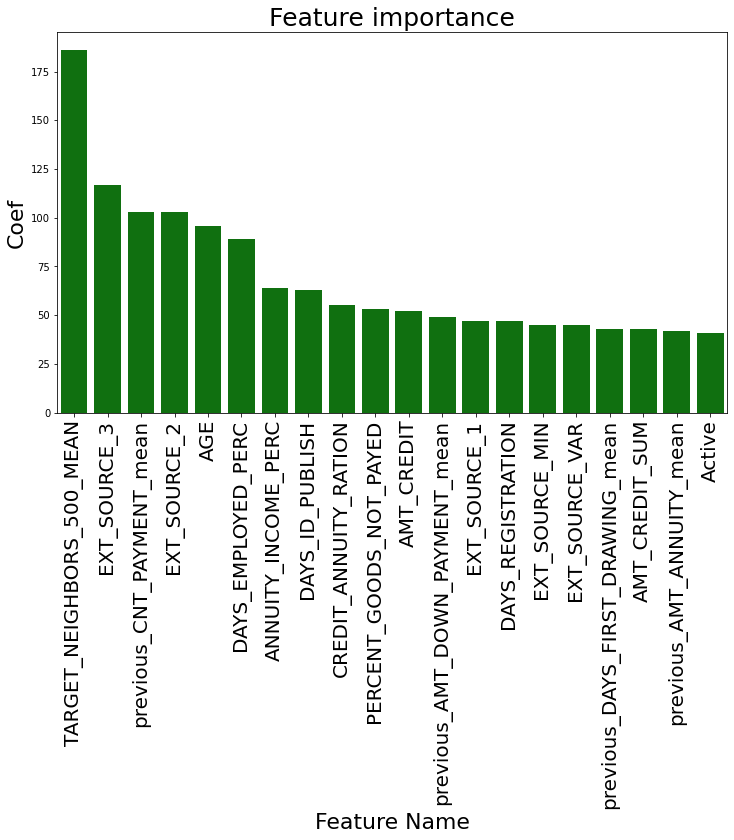

In [14]:
features_importance(X, lgb)

# 4. Tuning des parametres

### 4.1. Xgboost

In [48]:
class TuningRegressor_XGB:
    def __init__(self, search_space=None, random_state=42): 
        self.search_space = search_space
        self.random_state = random_state

    def hyperparameter_tuning(self, space):
        print(space['max_depth'])
        model=XGBClassifier(
                    n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
        model.fit(X_train_o, y_train_o)

        y_pred = model.predict(X_test)
        fbeta = fbeta_score(y_test, y_pred, average='macro', beta=3)
        return {'loss': -fbeta, 'status': STATUS_OK, 'model': model}

    def optimisation(self):
        best_params= {}
        if self.search_space : 
            trials = Trials()
            best_params = fmin(fn=self.hyperparameter_tuning,
                                space=self.search_space,
                                algo=tpe.suggest,
                                max_evals=10,
                                trials=trials, 
                                verbose=1)
            best_params = space_eval(self.search_space, best_params)
            fnvals = [t['result']['loss'] for t in trials.trials]
            best_loss = min(fnvals)
            
        return best_params, best_loss

In [49]:
space={
    'max_depth': hp.quniform("max_depth", 1, 20, 1),
    'gamma': hp.uniform('gamma', 1, 12),
    'reg_alpha' : hp.quniform('reg_alpha', 40, 200, 1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'booster':hp.choice("booster", ["gbtree", "dart"]),
    'objective':hp.choice("objective", ['reg:squaredlogerror', 'reg:squarederror']), 
    'n_estimators': hp.choice('n_estimators', range(100, 200, 10)),
    'learning_rate': hp.quniform('learning_rate', 0.01, 0.5, 0.01 )
}

best_params, best_loss = TuningRegressor_XGB(search_space=space).optimisation()

2.0                                                                                                                    
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:17:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
5.0                                                                                                                    
 10%|████▊                                           | 1/10 [00:07<01:08,  7.60s/trial, best loss: -0.5591540143918404]

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:17:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
2.0                                                                                                                    
 20%|█████████▌                                      | 2/10 [00:15<01:02,  7.81s/trial, best loss: -0.5773559648219965]

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:18:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6.0                                                                                                                    
 30%|██████████████▍                                 | 3/10 [00:25<01:02,  8.97s/trial, best loss: -0.5910717476350461]

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:18:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
9.0                                                                                                                    
 40%|███████████████████▏                            | 4/10 [00:35<00:55,  9.17s/trial, best loss: -0.5910717476350461]

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:18:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
14.0                                                                                                                   
 50%|████████████████████████                        | 5/10 [00:47<00:50, 10.12s/trial, best loss: -0.5910717476350461]

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:18:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
4.0                                                                                                                    
 60%|████████████████████████████▊                   | 6/10 [00:56<00:39,  9.92s/trial, best loss: -0.5910717476350461]

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:18:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
2.0                                                                                                                    
 70%|█████████████████████████████████▌              | 7/10 [01:06<00:29,  9.78s/trial, best loss: -0.5910717476350461]

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:18:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
20.0                                                                                                                   
 80%|██████████████████████████████████████▍         | 8/10 [01:14<00:18,  9.28s/trial, best loss: -0.5910717476350461]

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:19:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
7.0                                                                                                                    
 90%|███████████████████████████████████████████▏    | 9/10 [01:26<00:10, 10.04s/trial, best loss: -0.6012998052733698]

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:19:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
100%|███████████████████████████████████████████████| 10/10 [01:40<00:00, 10.02s/trial, best loss: -0.6035004829192188]


### 4.2 LGB

In [15]:
class TuningRegressor_LGB:
    def __init__(self, search_space=None, random_state=42): 
        self.search_space = search_space
        self.random_state = random_state

    def hyperparameter_tuning(self, space):
        model = LGBMClassifier(
            num_leaves=int(space['num_leaves']),
            max_bin=int(space['max_bin']),
            min_child_samples=int(space['min_child_samples']),
            n_estimators=int(space['n_estimators']),
            reg_alpha=int(space['reg_alpha']),
            reg_lambda=int(space['reg_lambda'])
        )
        model.fit(X_train_o, y_train_o)

        y_pred = model.predict(X_test)
        fbeta = fbeta_score(y_test, y_pred, average='macro', beta=3)
        return {'loss': -fbeta, 'status': STATUS_OK, 'model': model}

    def optimisation(self):
        best_params= {}
        if self.search_space : 
            trials = Trials()
            best_params = fmin(fn=self.hyperparameter_tuning,
                                space=self.search_space,
                                algo=tpe.suggest,
                                max_evals=20,
                                trials=trials, 
                                verbose=1)
            best_params = space_eval(self.search_space, best_params)
            fnvals = [t['result']['loss'] for t in trials.trials]
            best_loss = min(fnvals)
            
        return best_params, best_loss

In [16]:
space={
    'num_leaves': hp.quniform("num_leaves", 10, 100, 10),
    'max_bin' : hp.quniform('max_bin', 500, 1500, 500),
    'min_child_samples' : hp.quniform('min_child_samples', 500, 1000, 10),
    'n_estimators': hp.choice('n_estimators', range(50, 300, 10)),
    'reg_alpha': hp.quniform('reg_alpha', 0.01, 0.5, 0.01 ),
    'reg_lambda': hp.quniform('reg_lambda', 0.01, 0.5, 0.01 )
}

best_params, best_loss = TuningRegressor_LGB(search_space=space).optimisation()

100%|███████████████████████████████████████████████| 20/20 [08:22<00:00, 25.13s/trial, best loss: -0.6551049242960649]


# 5. Save best model and data for the dashboard

## 5.1 Model

In [17]:
X_o, y_o = oversample.fit_resample(X, y)

lgb = LGBMClassifier(
    num_leaves=int(best_params['num_leaves']),
    max_bin=int(best_params['max_bin']),
    min_child_samples=int(best_params['min_child_samples']),
    n_estimators=int(best_params['n_estimators']),
    reg_alpha=int(best_params['reg_alpha']),
    reg_lambda=int(best_params['reg_lambda'])
)

scores = cross_val_score(lgb, X_o, y_o, cv=kfold, scoring=ftwo_scorer)
scores

array([0.89410528, 0.89450369, 0.89205112, 0.8922561 , 0.89178504])

In [18]:
X_o.drop(columns=['SK_ID_CURR'], inplace=True)

In [19]:
model = lgb.fit(X_o, y_o)

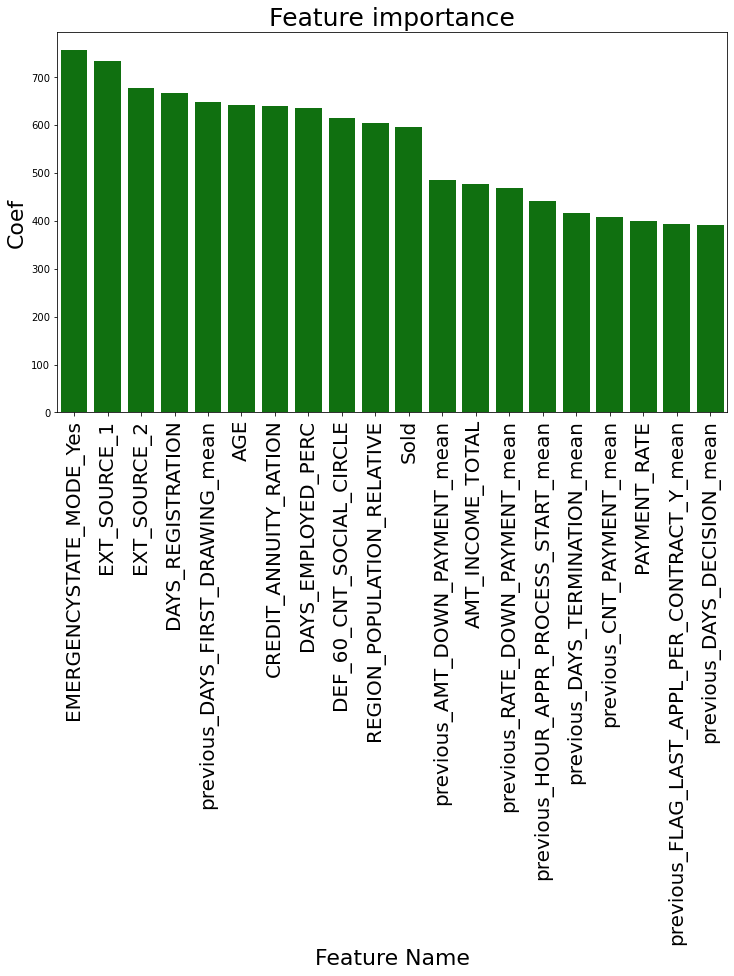

In [20]:
features_importance(X, lgb)

In [32]:
import joblib
# save model
joblib.dump(model, 'backend/data/model/xgboost_fake.pkl')

['backend/data/model/xgboost_fake.pkl']

In [16]:
import joblib
# save model
model = joblib.load('backend/data/model/lgb.pkl')

In [17]:
model

LGBMClassifier(max_bin=1000, min_child_samples=900, n_estimators=260,
               num_leaves=100, reg_alpha=0, reg_lambda=0)

In [20]:
joblib.dump(model, 'backend/data/model/lgb_compress.pkl', compress=9)

['backend/data/model/lgb_compress.pkl']

## 5.2 Test data

In [22]:
train_data_for_neighbors = app_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATION']].fillna(0)
train_target = y
test_data_for_neighbors = app_test[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATION']].fillna(0)

knn = KNeighborsClassifier(500, n_jobs = -1)
knn.fit(train_data_for_neighbors, train_target)
train_500_neighbors = knn.kneighbors(train_data_for_neighbors)[1]
test_500_neighbors = knn.kneighbors(test_data_for_neighbors)[1]

#adding the means of targets of 500 neighbors to new column
app_train['TARGET_NEIGHBORS_500_MEAN'] = [y.iloc[ele].mean() for ele in train_500_neighbors]
app_test['TARGET_NEIGHBORS_500_MEAN'] = [y.iloc[ele].mean() for ele in test_500_neighbors]

In [23]:
app_test = app_test.fillna(0)

In [37]:
app_test.to_csv('data/model/clients_data.csv', index=False)

## 5.3 Data to construct graphs

In [2]:
app_train, app_test = Preprocessing(encode_columns_bool=False).run()

y = app_train['TARGET']
train_data_for_neighbors = app_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATION']].fillna(0)
train_target = y
test_data_for_neighbors = app_test[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATION']].fillna(0)

knn = KNeighborsClassifier(500, n_jobs = -1)
knn.fit(train_data_for_neighbors, train_target)
train_500_neighbors = knn.kneighbors(train_data_for_neighbors)[1]
test_500_neighbors = knn.kneighbors(test_data_for_neighbors)[1]

#adding the means of targets of 500 neighbors to new column
app_train['TARGET_NEIGHBORS_500_MEAN'] = [y.iloc[ele].mean() for ele in train_500_neighbors]
app_test['TARGET_NEIGHBORS_500_MEAN'] = [y.iloc[ele].mean() for ele in test_500_neighbors]

app_train = app_train.fillna(0)
app_test = app_test.fillna(0)

In [3]:
X = app_train.drop(columns = ['TARGET'])
y = app_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=42, stratify=y)

In [4]:
graph_data = pd.concat([X_test, y_test], axis=1)
graph_data

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,...,previous_HOUR_APPR_PROCESS_START_mean,previous_SELLERPLACE_AREA_mean,previous_AMT_DOWN_PAYMENT_mean,previous_AMT_ANNUITY_mean,previous_AMT_CREDIT_mean,previous_AMT_APPLICATION_mean,previous_AMT_GOODS_PRICE_mean,previous_DAYS_FIRST_DRAWING_mean,TARGET_NEIGHBORS_500_MEAN,TARGET
7003,108154,Revolving loans,N,Y,2,135000.0,405000.0,405000.0,Unaccompanied,Working,...,11.571429,91.714286,5201.250000,13653.977539,239697.640625,225641.578125,225641.578125,365243.0,0.036,1
185156,314630,Cash loans,N,N,0,135000.0,523237.5,432000.0,Unaccompanied,Working,...,14.800000,27.800000,751.500000,11104.343750,71820.000000,70420.500000,70420.500000,365243.0,0.140,0
113080,231152,Cash loans,N,Y,0,153000.0,284400.0,225000.0,Unaccompanied,Working,...,12.000000,-1.000000,0.000000,13562.325195,119925.000000,112500.000000,112500.000000,365243.0,0.014,0
4036,104722,Cash loans,N,N,0,63000.0,521280.0,450000.0,Family,Pensioner,...,10.000000,83.000000,0.000000,4200.209961,36499.500000,33210.000000,33210.000000,365243.0,0.032,0
105788,222749,Cash loans,Y,Y,0,117000.0,148500.0,148500.0,Unaccompanied,Working,...,10.166667,30.166667,13500.674805,14295.071289,184582.500000,167413.718750,251120.593750,365243.0,0.024,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293034,439480,Cash loans,N,N,0,103500.0,112068.0,99000.0,Unaccompanied,Working,...,15.000000,21.000000,9002.700195,8149.364746,44229.375000,36985.050781,73970.101562,365243.0,0.100,0
295168,441958,Cash loans,N,N,0,112500.0,607500.0,607500.0,Unaccompanied,Pensioner,...,10.750000,30.750000,1573.875000,9770.321289,278940.375000,258937.312500,258937.312500,365243.0,0.014,0
45442,152633,Cash loans,Y,Y,0,180000.0,454500.0,454500.0,Unaccompanied,Commercial associate,...,9.000000,3268.000000,0.000000,4684.522461,41566.500000,40497.750000,40497.750000,365243.0,0.082,0
212032,345707,Cash loans,Y,N,2,315000.0,545040.0,450000.0,Unaccompanied,Commercial associate,...,15.400000,240.200000,10882.500000,10849.151367,75029.398438,80846.101562,101057.625000,365243.0,0.106,0


In [10]:
list(graph_data.select_dtypes(['int64', 'float64']).columns)

['DAYS_EMPLOYED_PERC',
 'EXT_SOURCE_MAX',
 'EXT_SOURCE_MIN',
 'EXT_SOURCE_VAR',
 'Active',
 'Bad debt',
 'Closed',
 'Sold',
 'AMT_CREDIT_SUM',
 'previous_NAME_GOODS_CATEGORY_Animals_mean',
 'previous_NAME_GOODS_CATEGORY_House Construction_mean',
 'previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean',
 'previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean',
 'previous_NAME_CASH_LOAN_PURPOSE_Hobby_mean',
 'previous_NAME_GOODS_CATEGORY_Education_mean',
 'previous_NAME_GOODS_CATEGORY_Additional Service_mean',
 'previous_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_mean',
 'previous_NAME_CASH_LOAN_PURPOSE_Buying a garage_mean',
 'previous_NAME_GOODS_CATEGORY_Insurance_mean',
 'previous_NAME_CASH_LOAN_PURPOSE_Business development_mean',
 'previous_NAME_GOODS_CATEGORY_Fitness_mean',
 'previous_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_mean',
 'previous_NAME_SELLER_INDUSTRY_MLM partners_mean',
 'previous_NAME_GOODS_CATEGORY_Direct Sales_mean',
 'previous_NAME_CAS

In [5]:
app_test.to_csv('data/app_test_no_encoded_data.csv', index=False)

In [6]:
graph_data.to_csv('data/sample_app_train_no_encoded_data.csv', index=False)

## 5.4 Lime explainer

In [83]:
data_model = pd.read_csv('data/model/clients_data_predictions.csv')
data_model.drop(columns=['SK_ID_CURR'], inplace=True)

In [85]:
explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(data_model),
    feature_names = data_model.columns,
    class_names=['payed', 'did not pay'],
    mode='classification')

In [86]:
with open('data/explainer', 'wb') as f:
    dill.dump(explainer, f)

In [163]:
model = joblib.load('data/model/lgb.pkl')
train = pd.read_csv('data/sample_app_trai.csv')
data_model = pd.read_csv('data/model/clients_data.csv')
data_model.drop(columns=['SK_ID_CURR'], inplace=True)